In [1]:
!nvidia-smi

Fri Jun 16 05:00:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pandarallel==1.6.4
!pip install opencc
!pip install hanlp
!pip install transformers==4.27.1
!pip install wikipedia==1.4.0
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 3.7 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16663 sha256=007df15e09f424a9d642ee21ebc2f7281533e1a20e324775f8db84a62eced006
  Stored in directory: /root/.cache/pip/wheels/80/3a/18/ad02ff58953d0aea45e4f30682a40974b336626a50fe4a2f90
Successfully built pandarallel
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.3/778.3 kB 12.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 651.1/651.1 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... don

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!cp drive/MyDrive/碩士/碩一下/高等深度學習/期末/utils.py .
!cp drive/MyDrive/碩士/碩一下/高等深度學習/期末/dataset.py .
!cp drive/MyDrive/碩士/碩一下/高等深度學習/期末/pytorchtools.py .

save_path = '/content/drive/MyDrive/碩士/碩一下/高等深度學習/期末/'

In [27]:
from opencc import OpenCC
from tqdm import tqdm

# built-in libs
import json
import pickle
import re
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union

# 3rd party libs
import hanlp
import opencc
import pandas as pd
import wikipedia
from hanlp.components.pipeline import Pipeline
from pandarallel import pandarallel

# our own libs
from utils import load_json
from pytorchtools import EarlyStopping

import matplotlib.pyplot as plt

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=12)
wikipedia.set_lang("zh")

In [6]:

@dataclass
class Claim:
    r"""
    陳述句: str
    """
    data: str

@dataclass
class AnnotationID:
    r"""
    註解編號
    """
    id: int

@dataclass
class EvidenceID:
    r"""
    證據句編號
    """
    id: int

@dataclass
class PageTitle:
    r"""
    維基百科文章標題
    """
    title: str

@dataclass
class SentenceID:
    r"""
    維基百科文章句子編號
    """
    id: int

@dataclass
class Evidence:
    r"""
    陳述證據句
    來自維基百科文章中的句子
    包含哪一篇文章、文章句子編號
    """
    data: List[List[Tuple[AnnotationID, EvidenceID, PageTitle, SentenceID]]]

#### 第一階段：資料前處理: 確定要搜尋的wiki文章

In [14]:
TRAIN_DATA = load_json(save_path + "train.jsonl")
# with open(save_path + "train.jsonl", "r", encoding="utf8") as json_file:
#     json_list = list(json_file)

# TRAIN_DATA = []
# for json_str in json_list:
#     TRAIN_DATA.append(json.loads(json_str))

CONVERTER_T2S = opencc.OpenCC("t2s")
CONVERTER_S2T = opencc.OpenCC("s2t")

In [15]:
def do_st_corrections(text: str) -> str:
    r"""
    透過OpenCC將繁體中文轉換成簡體中文，再轉換回繁體中文

    Args:
        text (str): 要轉換的文字
    """
    simplified = CONVERTER_T2S.convert(text)
    return CONVERTER_S2T.convert(simplified)

In [16]:
def get_nps_hanlp(
    predictor: Pipeline,
    d: Dict[str, Union[int, Claim, Evidence]],
) -> List[str]:
    r"""
    透過HanLP的parser取得claim的名詞片語

    Args:
        predictor (Pipeline): HanLP的parser

        d (Dict[str, Union[int, Claim, Evidence]]): claim的資料

    Returns:
        List[str]: claim的名詞片語

    """
    claim = d["claim"]
    tree = predictor(claim)["con"]
    nps = [
        do_st_corrections("".join(subtree.leaves()))
        for subtree in tree.subtrees(lambda t: t.label() == "NP" or t.label() == "A")
    ]

    return nps

In [17]:
def calculate_precision(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    r"""
    計算精確度

    Args:
        data (List[Dict[str, Union[int, Claim, Evidence]]]): claim的資料

        predictions (pd.Series): 預測的結果

    """
    precision = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        # Extract all ground truth of titles of the wikipedia pages
        # evidence[2] refers to the title of the wikipedia page
        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])

        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        if len(predicted_pages) != 0:
            precision += len(hits) / len(predicted_pages)

        count += 1

    # Macro precision
    print(f"Precision: {precision / count}")


def calculate_recall(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
) -> None:
    r"""
    計算召回率

    Args:
        data (List[Dict[str, Union[int, Claim, Evidence]]]): claim的資料

        predictions (pd.Series): 預測的結果

    """
    recall = 0
    count = 0

    for i, d in enumerate(data):
        if d["label"] == "NOT ENOUGH INFO":
            continue

        gt_pages = set([
            evidence[2]
            for evidence_set in d["evidence"]
            for evidence in evidence_set
        ])
        predicted_pages = predictions.iloc[i]
        hits = predicted_pages.intersection(gt_pages)
        recall += len(hits) / len(gt_pages)
        count += 1

    print(f"Recall: {recall / count}")

In [18]:
def save_doc(
    data: List[Dict[str, Union[int, Claim, Evidence]]],
    predictions: pd.Series,
    mode: str = "train",
    num_pred_doc: int = 5,
) -> None:

    r"""
    將預測的結果存成jsonl檔

    Args:
        data (List[Dict[str, Union[int, Claim, Evidence]]]): claim的資料

        predictions (pd.Series): 預測的結果

        mode (str, optional): 資料集的模式. 預設為"train"

        num_pred_doc (int, optional): 預測的數量. 預設值為5

    """
    with open(
        save_path + f"data/{mode}_doc{num_pred_doc}.jsonl",
        "w",
        encoding="utf8",
    ) as f:
        for i, d in enumerate(data):
            d["predicted_pages"] = list(predictions.iloc[i])
            f.write(json.dumps(d, ensure_ascii=False) + "\n")

In [19]:
def get_pred_pages(series_data: pd.Series) -> Set[Dict[int, str]]:

    r"""
    傳入敘述句，使用Wikipedia API查詢名詞片語
    過濾出需要查詢的名詞片語

    Args:
        series_data (pd.Series): claim的資料

    Returns:
        Set[Dict[int, str]]: 需要查詢的名詞片語

    """
    results = []
    tmp_muji = []
    # wiki_page: its index showned in claim
    mapping = {}
    claim = series_data["claim"]
    nps = series_data["hanlp_results"]
    first_wiki_term = []

    for i, np in enumerate(nps):
        # Simplified Traditional Chinese Correction
        # 使用Wikipedia API搜尋名詞片語
        # 使用OpenCC將簡體中文轉換成繁體中文
        # 轨道 (力学) -> 軌道 (力學)
        wiki_search_results = [
            do_st_corrections(w) for w in wikipedia.search(np)
        ]

        # Remove the wiki page's description in brackets
        # 移除wiki搜尋結果中，括號內的描述
        # 軌道 (力學) -> 軌道
        wiki_set = [re.sub(r"\s\(\S+\)", "", w) for w in wiki_search_results]
        wiki_df = pd.DataFrame({
            "wiki_set": wiki_set, # 將去除括號後的文章標題作為類別
            "wiki_results": wiki_search_results # 原始文章的標題
        })

        # Elements in wiki_set --> index
        # Extracting only the first element is one way to avoid extracting
        # too many of the similar wiki pages
        # 透過wiki_set欄位合併wiki_df，並取得第一個wiki_set的值
        # 擷取第一個wiki_set的值，是為了避免擷取太多相似的wiki頁面
        # grouped_df = wiki_df.groupby("wiki_set", sort=False).first()
        grouped_df = wiki_df
        candidates = grouped_df["wiki_results"].tolist()
        # muji refers to wiki_set
        muji = grouped_df.index.tolist()

        for prefix, term in zip(muji, candidates):
            # 若prefix(類別)已經出現過，則不再重複擷取
            if prefix not in tmp_muji:
                matched = False

                # Take at least one term from the first noun phrase
                # 如果是第一個名詞片語，至少要取一個名詞片語
                if i == 0:
                    first_wiki_term.append(term)

                # Walrus operator :=
                # https://docs.python.org/3/whatsnew/3.8.html#assignment-expressions
                # Through these filters, we are trying to figure out if the term
                # is within the claim
                # 透過取代.、空白、-，來判斷term是否在claim中
                if (((new_term := term) in claim) or
                    ((new_term := term.replace("·", "")) in claim) or
                    ((new_term := term.split(" ")[0]) in claim) or
                    ((new_term := term.replace("-", " ")) in claim)):
                    matched = True

                # term未出現在claim中，但term中有.，則以.為分隔符號，判斷term是否在claim中
                elif "·" in term:
                    splitted = term.split("·")
                    for split in splitted:
                        if (new_term := split) in claim:
                            matched = True
                            break

                # 發現term在claim中，進行後處理
                if matched:
                    # post-processing
                    # 將term中的 '-' -> '', ' ' -> '_'
                    term = term.replace(" ", "_")
                    term = term.replace("-", "")
                    results.append(term)
                    # 將文章中與claim相符的部分，以term為key，claim中相符的部分為value(句子中相符合名詞的index)
                    mapping[term] = claim.find(new_term)
                    # 將term加入tmp_muji中，避免重複擷取
                    tmp_muji.append(new_term)

    # 5 is a hyperparameter
    # 若取得的term超過5個，則取mapping中value最小的5個term（最早出現的5個term）
    if len(results) > 5:
        assert -1 not in mapping.values()
        results = sorted(mapping, key=mapping.get)[:5]
    elif len(results) < 1:
        # 至少回傳一個term
        results = first_wiki_term

    return set(results)

##### hanlp Constituency Parsing Tree Predictor
用來切割出陳述句中的名詞片語

In [20]:
predictor = (hanlp.pipeline().append(
    hanlp.load("FINE_ELECTRA_SMALL_ZH"),
    output_key="tok",
).append(
    hanlp.load("CTB9_CON_ELECTRA_SMALL"),
    output_key="con",
    input_key="tok",
))

100%  43.5 MiB  27.9 MiB/s ETA:  0 s [=========================================]
Decompressing /root/.hanlp/tok/fine_electra_small_20220615_231803.zip to /root/.hanlp/tok
100%  26.7 KiB  26.7 KiB/s ETA:  0 s [=========================================]
Decompressing /root/.hanlp/utils/char_table_20210602_202632.json.zip to /root/.hanlp/utils
100%  41.2 KiB  41.2 KiB/s ETA:  0 s [=========================================]
Decompressing /root/.hanlp/transformers/electra_zh_small_20210706_125427.zip to /root/.hanlp/transformers
100%  54.8 MiB  54.8 MiB/s ETA:  0 s [=========================================]
Decompressing /root/.hanlp/constituency/ctb9_con_electra_small_20220215_230116.zip to /root/.hanlp/constituency


使用hanlp Constituency Parsing Tree進行句子轉換並找出名詞

In [21]:
NUM_PRED_DOC = 5

In [22]:
hanlp_file = save_path + "data1/hanlp_con_results_{}.pkl".format(NUM_PRED_DOC)

# 若hanlp_file存在，則讀取檔案
if Path(hanlp_file).exists():
    with open(hanlp_file, "rb") as f:
        hanlp_results = pickle.load(f)
else:
    # 若hanlp_file不存在，則重新計算
    # 使用hanlp套件對claim進行斷詞，並取得名詞片語
    hanlp_results = [get_nps_hanlp(predictor, d) for d in TRAIN_DATA]
    with open(hanlp_file, "wb") as f:
        pickle.dump(hanlp_results, f)

In [28]:
doc_path = save_path + "data1/train_doc{}.jsonl".format(NUM_PRED_DOC)
# 若doc_path存在，則讀取檔案
if Path(doc_path).exists():
    with open(doc_path, "r", encoding="utf8") as f:
        predicted_results = pd.Series([
            set(json.loads(line)["predicted_pages"])
            for line in f
        ])
else:
    # 若doc_path不存在，則重新計算
    train_df = pd.DataFrame(TRAIN_DATA)
    # 將hanlp_results (斷詞結果)加入train_df
    train_df.loc[:, "hanlp_results"] = hanlp_results
    # 將train_df傳入get_pred_pages函式，取得需要查詢的名詞片語
    predicted_results = train_df.parallel_apply(get_pred_pages, axis=1)
    save_doc(TRAIN_DATA, predicted_results, mode="train", num_pred_doc=NUM_PRED_DOC)

In [29]:
calculate_precision(TRAIN_DATA, predicted_results)
calculate_recall(TRAIN_DATA, predicted_results)

Precision: 0.24815064390535843
Recall: 0.8064390536088648


#### 第二階段：語句檢索: 找出與搜尋關鍵字相關的wiki文章
- 先找出相關文章，並抽取相關的句子作為證據句
- 將陳述句與句子丟入bert模型進行分類：證據句 or 非證據句

In [30]:
# built-in libs
from pathlib import Path
from typing import Dict, List, Set, Tuple, Union

# third-party libs
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler,
)

from dataset import BERTDataset, Dataset

# local libs
from utils import (
    generate_evidence_to_wiki_pages_mapping,
    jsonl_dir_to_df,
    load_json,
    load_model,
    save_checkpoint,
    set_lr_scheduler,
)

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=10)

In [31]:
SEED = 42

TRAIN_DATA = load_json(save_path + "train.jsonl")
DOC_DATA = load_json(save_path + "data/train_doc{}.jsonl".format(NUM_PRED_DOC))

LABEL2ID: Dict[str, int] = {
    "supports": 0,
    "refutes": 1,
    "NOT ENOUGH INFO": 2,
}
ID2LABEL: Dict[int, str] = {v: k for k, v in LABEL2ID.items()}

_y = [LABEL2ID[data["label"]] for data in TRAIN_DATA]
# GT means Ground Truth
TRAIN_GT, DEV_GT = train_test_split(
    DOC_DATA,
    test_size=0.2,
    random_state=SEED,
    shuffle=True,
    stratify=_y,
)

In [32]:
wiki_pages = jsonl_dir_to_df(save_path + "data/wiki-pages")
mapping = generate_evidence_to_wiki_pages_mapping(wiki_pages)
del wiki_pages

Reading and concatenating jsonl files in /content/drive/MyDrive/碩士/碩一下/高等深度學習/期末/data/wiki-pages
Generate parse mapping


Transform to id to evidence_map mapping


In [33]:
mapping['臺灣海峽']

{'0': '臺灣海峽 （ 俗稱烏水溝 ， 臺語 : Oo - tsúi - kau ； 歐洲早期稱福爾摩沙海峽 ） 指的是介於中國大陸與臺灣之間的海域和海峽 ， 北東 — 南西走向 ， 長約370公里 ， 北窄南寬 ， 北口寬約200公里 ， 南口寬約410公里 ， 平均寬度180公里 ， 最窄處在臺灣側新竹市南寮與福建側平潭海壇島之間 ， 約126公里 ， 以大陸架爲主 ， 其水深 （ 岩牀最大深度 ） 爲70米 ， 總面積約8萬平方公里 。',
 '1': '',
 '2': '',
 '3': '臺灣海峽在地理學上是南海及太平洋的一部分 ， 北以臺灣側最北端富貴角到大陸福建側平潭島連線 ， 南則是以臺灣側最南端鵝鑾鼻到大陸福建側東山島連線爲界 。',
 '4': '海域上的島嶼 ， 除靠近福建的沿海大陸島外 ， 尚有澎湖群島與屏東縣的小琉球 。',
 '5': '',
 '6': '',
 '7': '地理學上 ， 臺灣海峽爲東海及西太平洋的一部分 ， 位於東海及南海之間 ， 爲東洋海洋史上貿易路線的重要水道 ， 又因其位於中國大陸及太平洋之間 ， 爲近代地緣政治戰略要點之一 。',
 '8': ''}

In [34]:
def evidence_macro_precision(
    instance: Dict,
    top_rows: pd.DataFrame,
) -> Tuple[float, float]:
    """Calculate precision for sentence retrieval
    This function is modified from fever-scorer.
    https://github.com/sheffieldnlp/fever-scorer/blob/master/src/fever/scorer.py

    Args:
        instance (dict): a row of the dev set (dev.jsonl) of test set (test.jsonl)
        top_rows (pd.DataFrame): our predictions with the top probabilities

        IMPORTANT!!!
        instance (dict) should have the key of `evidence`.
        top_rows (pd.DataFrame) should have a column `predicted_evidence`.

    Returns:
        Tuple[float, float]:
        [1]: relevant and retrieved (numerator of precision)
        [2]: retrieved (denominator of precision)
    """
    this_precision = 0.0
    this_precision_hits = 0.0

    # Return 0, 0 if label is not enough info since not enough info does not
    # contain any evidence.
    if instance["label"].upper() != "NOT ENOUGH INFO":
        # e[2] is the page title, e[3] is the sentence index
        all_evi = [[e[2], e[3]]
                   for eg in instance["evidence"]
                   for e in eg
                   if e[3] is not None]
        claim = instance["claim"]
        predicted_evidence = top_rows[top_rows["claim"] ==
                                      claim]["predicted_evidence"].tolist()

        for prediction in predicted_evidence:
            if prediction in all_evi:
                this_precision += 1.0
            this_precision_hits += 1.0

        return (this_precision /
                this_precision_hits) if this_precision_hits > 0 else 1.0, 1.0

    return 0.0, 0.0

def evidence_macro_recall(
    instance: Dict,
    top_rows: pd.DataFrame,
) -> Tuple[float, float]:
    """Calculate recall for sentence retrieval
    This function is modified from fever-scorer.
    https://github.com/sheffieldnlp/fever-scorer/blob/master/src/fever/scorer.py

    Args:
        instance (dict): a row of the dev set (dev.jsonl) of test set (test.jsonl)
        top_rows (pd.DataFrame): our predictions with the top probabilities

        IMPORTANT!!!
        instance (dict) should have the key of `evidence`.
        top_rows (pd.DataFrame) should have a column `predicted_evidence`.

    Returns:
        Tuple[float, float]:
        [1]: relevant and retrieved (numerator of recall)
        [2]: relevant (denominator of recall)
    """
    # We only want to score F1/Precision/Recall of recalled evidence for NEI claims
    if instance["label"].upper() != "NOT ENOUGH INFO":
        # If there's no evidence to predict, return 1
        if len(instance["evidence"]) == 0 or all(
            [len(eg) == 0 for eg in instance]):
            return 1.0, 1.0

        claim = instance["claim"]

        predicted_evidence = top_rows[top_rows["claim"] ==
                                      claim]["predicted_evidence"].tolist()

        for evidence_group in instance["evidence"]:
            evidence = [[e[2], e[3]] for e in evidence_group]
            if all([item in predicted_evidence for item in evidence]):
                # We only want to score complete groups of evidence. Incomplete
                # groups are worthless.
                return 1.0, 1.0
        return 0.0, 1.0
    return 0.0, 0.0

In [53]:
def evaluate_retrieval(
    probs: np.ndarray,
    df_evidences: pd.DataFrame,
    ground_truths: pd.DataFrame,
    top_n: int = 5,
    cal_scores: bool = True,
    save_name: str = None,
) -> Dict[str, float]:
    """Calculate the scores of sentence retrieval

    Args:
        probs (np.ndarray): probabilities of the candidate retrieved sentences
        df_evidences (pd.DataFrame): the candiate evidence sentences paired with claims
        ground_truths (pd.DataFrame): the loaded data of dev.jsonl or test.jsonl
        top_n (int, optional): the number of the retrieved sentences. Defaults to 2.

    Returns:
        Dict[str, float]: F1 score, precision, and recall
    """
    df_evidences["prob"] = probs
    top_rows = (
        df_evidences.groupby("claim").apply(
        lambda x: x.nlargest(top_n, "prob"))
        .reset_index(drop=True)
    )

    if cal_scores:
        macro_precision = 0
        macro_precision_hits = 0
        macro_recall = 0
        macro_recall_hits = 0

        for i, instance in enumerate(ground_truths):
            macro_prec = evidence_macro_precision(instance, top_rows)
            macro_precision += macro_prec[0]
            macro_precision_hits += macro_prec[1]

            macro_rec = evidence_macro_recall(instance, top_rows)
            macro_recall += macro_rec[0]
            macro_recall_hits += macro_rec[1]

        pr = (macro_precision /
              macro_precision_hits) if macro_precision_hits > 0 else 1.0
        rec = (macro_recall /
               macro_recall_hits) if macro_recall_hits > 0 else 0.0
        f1 = 2.0 * pr * rec / (pr + rec)

    if save_name is not None:
        # write doc7_sent5 file
        with open(save_path + f"data1/{save_name}", "w") as f:
            for instance in ground_truths:
                claim = instance["claim"]
                predicted_evidence = top_rows[
                    top_rows["claim"] == claim]["predicted_evidence"].tolist()
                instance["predicted_evidence"] = predicted_evidence
                f.write(json.dumps(instance, ensure_ascii=False) + "\n")

    if cal_scores:
        return {"F1 score": f1, "Precision": pr, "Recall": rec}

In [36]:
def get_predicted_probs(
    model: nn.Module,
    dataloader: Dataset,
    device: torch.device,
) -> np.ndarray:
    """Inference script to get probabilites for the candidate evidence sentences

    Args:
        model: the one from HuggingFace Transformers
        dataloader: devset or testset in torch dataloader

    Returns:
        np.ndarray: probabilites of the candidate evidence sentences
    """
    model.eval()
    probs = []

    with torch.no_grad():
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            probs.extend(torch.softmax(logits, dim=1)[:, 1].tolist())

    return np.array(probs)

In [37]:
class SentRetrievalBERTDataset(BERTDataset):
    """AicupTopkEvidenceBERTDataset class for AICUP dataset with top-k evidence sentences."""

    def __getitem__(
        self,
        idx: int,
        **kwargs,
    ) -> Tuple[Dict[str, torch.Tensor], int]:
        item = self.data.iloc[idx]
        sentA = item["claim"]
        sentB = item["text"]

        # claim [SEP] text
        concat = self.tokenizer(
            sentA,
            sentB,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        concat_ten = {k: torch.tensor(v) for k, v in concat.items()}
        if "label" in item:
            concat_ten["labels"] = torch.tensor(item["label"])

        return concat_ten


In [38]:
def pair_with_wiki_sentences(
    mapping: Dict[str, Dict[int, str]],
    df: pd.DataFrame,
    negative_ratio: float,
) -> pd.DataFrame:
    """Only for creating train sentences."""
    claims = []
    sentences = []
    labels = []

    # 支持
    for i in range(len(df)):
        # 若label為NOT ENOUGH INFO則跳過
        if df["label"].iloc[i] == "NOT ENOUGH INFO":
            continue

        claim = df["claim"].iloc[i]
        evidence_sets = df["evidence"].iloc[i]

        # 一個 '陳述句' 可能有多個 '證據組'
        for evidence_set in evidence_sets:
            sents = []

            # 每個 '證據組'可能有多個 '證據'
            for evidence in evidence_set:
                # evidence[2] 是文章的標題
                page = evidence[2].replace(" ", "_")
                # 唯一例外
                if page == "臺灣海峽危機#第二次臺灣海峽危機（1958）":
                    continue
                # evidence[3] 文章中的第幾句為證據，通常是一個數字，但mapping需要以str做key
                sent_idx = str(evidence[3])
                sents.append(mapping[page][sent_idx])

            whole_evidence = " ".join(sents)

            # 陳述句
            claims.append(claim)
            # 證據句
            sentences.append(whole_evidence)
            # 支持
            labels.append(1)

    # 反對
    for i in range(len(df)):
        # 若label為NOT ENOUGH INFO則跳過
        if df["label"].iloc[i] == "NOT ENOUGH INFO":
            continue

        # 陳述句
        claim = df["claim"].iloc[i]

        # 證據句
        evidence_set = set([(evidence[2], evidence[3])
                            for evidences in df["evidence"][i]
                            for evidence in evidences])

        # 要搜尋的wiki頁面
        predicted_pages = df["predicted_pages"][i]

        # 每個要頁面
        for page in predicted_pages:
            page = page.replace(" ", "_")
            try:
                page_sent_id_pairs = [
                    # sent_idx: wiki頁面中的第幾句
                    # page: wiki頁面
                    (page, sent_idx) for sent_idx in mapping[page].keys()
                ]
            except KeyError:
                # print("{} is not in our Wiki db.".format(page))
                continue

            # 每個wiki頁面中的每句
            for pair in page_sent_id_pairs:
                # 如果這句已經在證據中，則跳過
                if pair in evidence_set:
                    continue
                text = mapping[page][pair[1]]
                # `np.random.rand(1) <= 0.05`: Control not to add too many negative samples
                # 以0.05的機率加入反對的例子，避免太多反對的例子（資料不平衡）
                if text != "" and np.random.rand(1) <= negative_ratio:
                    claims.append(claim)
                    sentences.append(text)
                    labels.append(0)

    return pd.DataFrame({"claim": claims, "text": sentences, "label": labels})


def pair_with_wiki_sentences_eval(
    mapping: Dict[str, Dict[int, str]],
    df: pd.DataFrame,
    is_testset: bool = False,
) -> pd.DataFrame:
    """Only for creating dev and test sentences."""
    claims = []
    sentences = []
    evidence = []
    predicted_evidence = []

    # 反對
    for i in range(len(df)):
        # if df["label"].iloc[i] == "NOT ENOUGH INFO":
        #     continue

        # 陳述句
        claim = df["claim"].iloc[i]

        # 要搜尋的wiki頁面標題
        predicted_pages = df["predicted_pages"][i]

        # 每個要查詢頁面標題
        for page in predicted_pages:
            page = page.replace(" ", "_")
            try:
                # k: wiki頁面中的每句index與句子
                # page: wiki頁面標題
                page_sent_id_pairs = [(page, k) for k in mapping[page]]
            except KeyError:
                # print("{} is not in our Wiki db.".format(page))
                continue

            # 每個wiki頁面中的每句
            for page_name, sentence_id in page_sent_id_pairs:
                # 取得wiki頁面中的每句
                text = mapping[page][sentence_id]
                # 若該句不為空，則加入
                if text != "":
                    claims.append(claim)
                    sentences.append(text)

                    # 若為dev set，則加入evidence，若為test set，則不加入
                    if not is_testset:
                        evidence.append(df["evidence"].iloc[i])
                    predicted_evidence.append([page_name, int(sentence_id)])

    return pd.DataFrame({
        "claim": claims,
        "text": sentences,
        "evidence": evidence if not is_testset else None,
        "predicted_evidence": predicted_evidence,
    })

設定超參數

In [40]:
#@title  { display-mode: "form" }

# LERT
MODEL_NAME = "bert-base-chinese"  #@param {type:"string"}

# EPOCH
NUM_EPOCHS = 1  #@param {type:"integer"}

# 學習率
LR = 2e-5  #@param {type:"number"}

# 訓練 BATCH_SIZE
TRAIN_BATCH_SIZE = 64  #@param {type:"integer"}
# 測試 BATCH_SIZE
TEST_BATCH_SIZE = 256  #@param {type:"integer"}


NEGATIVE_RATIO = 0.03  #@param {type:"number"}


VALIDATION_STEP = 50  #@param {type:"integer"}

# 選擇前幾句作為證據句
TOP_N = 64  #@param {type:"integer"}

實驗設定

In [41]:
EXP_DIR = f"sent_retrieval/e{NUM_EPOCHS}_bs{TRAIN_BATCH_SIZE}_" + f"{LR}_neg{NEGATIVE_RATIO}_top{TOP_N}"
LOG_DIR = save_path + "logs1/" + EXP_DIR
CKPT_DIR = save_path + "checkpoints1/" + EXP_DIR

if not Path(LOG_DIR).exists():
    Path(LOG_DIR).mkdir(parents=True)

if not Path(CKPT_DIR).exists():
    Path(CKPT_DIR).mkdir(parents=True)


In [42]:
# 根據mapping將訓練集的claim和wiki的句子配對
train_df = pair_with_wiki_sentences(
    mapping,
    pd.DataFrame(TRAIN_GT),
    NEGATIVE_RATIO,
)

counts = train_df["label"].value_counts()
print("Now using the following train data with 0 (Negative) and 1 (Positive)")
print(counts)

dev_evidences = pair_with_wiki_sentences_eval(mapping, pd.DataFrame(DEV_GT))

Now using the following train data with 0 (Negative) and 1 (Positive)
1    1924
0    1882
Name: label, dtype: int64


In [43]:
dev_evidences

,claim,text,evidence,predicted_evidence
0,在1990年代被AFI挑選爲「AFI百年百大女明星」第16名的費雯 · 麗，是《亂世佳人》的...,明星是一種名人的代稱 ， 可以指 ：,"[[[6557, 6327, 費雯·麗, 5]]]","[明星, 0]"
1,在1990年代被AFI挑選爲「AFI百年百大女明星」第16名的費雯 · 麗，是《亂世佳人》的...,名可以指 ：,"[[[6557, 6327, 費雯·麗, 5]]]","[名, 0]"
2,在1990年代被AFI挑選爲「AFI百年百大女明星」第16名的費雯 · 麗，是《亂世佳人》的...,人或事物的名稱 ， 包括人名 、 地名等,"[[[6557, 6327, 費雯·麗, 5]]]","[名, 3]"
3,在1990年代被AFI挑選爲「AFI百年百大女明星」第16名的費雯 · 麗，是《亂世佳人》的...,名 ， 與色法合稱名色 。,"[[[6557, 6327, 費雯·麗, 5]]]","[名, 5]"
4,在1990年代被AFI挑選爲「AFI百年百大女明星」第16名的費雯 · 麗，是《亂世佳人》的...,在人名系統中 ， 名爲一個人專屬的名稱 ， 通常會與其家族姓氏 ， 組成一個人的全名 。,"[[[6557, 6327, 費雯·麗, 5]]]","[名_(人名), 0]"
...,...,...,...,...
18475,音樂劇天鵝湖於1877年在莫斯科大劇院首演。,莫斯科市 （ Москва ） 是俄羅斯首都以及最大都市 ， 爲俄羅斯全國政治 、 經濟 、...,"[[[1817, 1961, 天鵝湖, 0]]]","[莫斯科, 0]"
18476,音樂劇天鵝湖於1877年在莫斯科大劇院首演。,"面積 2,510 平方公里 ， 與莫斯科州和卡盧加州接壤 。","[[[1817, 1961, 天鵝湖, 0]]]","[莫斯科, 1]"
18477,音樂劇天鵝湖於1877年在莫斯科大劇院首演。,2022年城區人口超過1263萬 ， 都會區人口超過1700萬 ， 是歐洲最大的城市 ， 佔...,"[[[1817, 1961, 天鵝湖, 0]]]","[莫斯科, 2]"
18478,音樂劇天鵝湖於1877年在莫斯科大劇院首演。,莫斯科沿莫斯科河而建 ， 由1147年的莫斯科大公時代開始 ， 在沙皇俄國 、 蘇聯及今日的...,"[[[1817, 1961, 天鵝湖, 0]]]","[莫斯科, 3]"


訓練模型

In [44]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = SentRetrievalBERTDataset(train_df, tokenizer=tokenizer)
val_dataset = SentRetrievalBERTDataset(dev_evidences, tokenizer=tokenizer)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
)
eval_dataloader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE)

In [45]:
del train_df

創建模型、優化器等

In [46]:
device = 'cuda'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = set_lr_scheduler(optimizer, num_training_steps)

writer = SummaryWriter(LOG_DIR)

開始訓練

In [47]:
progress_bar = tqdm(range(num_training_steps))
current_steps = 0
first_all_train_loss = []
first_all_val_loss = []

for epoch in range(NUM_EPOCHS):
    train_loss = 0
    val_loss = 0

    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        writer.add_scalar("training_loss", loss.item(), current_steps)
        train_loss += loss.item()

        y_pred = torch.argmax(outputs.logits, dim=1).tolist()
        y_true = batch["labels"].tolist()

        current_steps += 1

        if current_steps % VALIDATION_STEP == 0 and current_steps > 0:
            print("Start validation")
            probs = get_predicted_probs(model, eval_dataloader, device)
            print("probs: ", probs, len(probs), type(probs))

            val_results = evaluate_retrieval(
                probs=probs,
                df_evidences=dev_evidences,
                ground_truths=DEV_GT,
                top_n=TOP_N,
            )
            print(val_results)

            # log each metric separately to TensorBoard
            for metric_name, metric_value in val_results.items():
                writer.add_scalar(
                    f"dev_{metric_name}",
                    metric_value,
                    current_steps,
                )

            save_checkpoint(model, CKPT_DIR, current_steps)

    first_all_train_loss.append(train_loss)
    first_all_val_loss.append(val_loss)

print("Finished training!")

  0%|          | 0/60 [00:00<?, ?it/s]

Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

probs:  [0.05603263 0.04990816 0.04957889 ... 0.04162889 0.06639501 0.06204863] 18480 <class 'numpy.ndarray'>
{'F1 score': 0.09176895336240684, 'Precision': 0.048843893724738165, 'Recall': 0.7573033707865169}
Finished training!


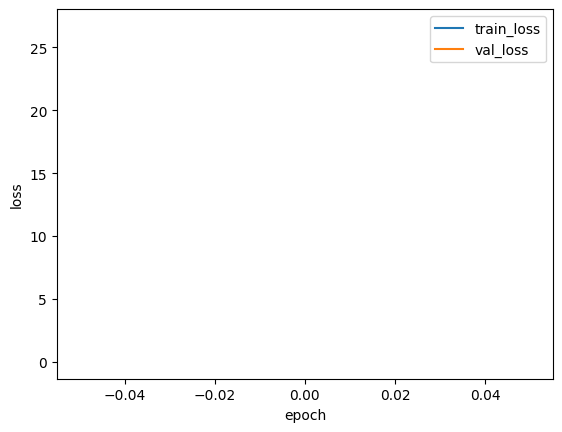

[26.705782368779182] [0]


In [48]:
# 顯示訓練過程中的loss
plt.plot(first_all_train_loss, label='train_loss')
plt.plot(first_all_val_loss, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()
print(first_all_train_loss, first_all_val_loss)

驗證

In [49]:
ckpt_name = "model.50.pt"
model = load_model(model, ckpt_name, CKPT_DIR)
print("Start final evaluations and write prediction files.")

train_evidences = pair_with_wiki_sentences_eval(
    mapping=mapping,
    df=pd.DataFrame(TRAIN_GT),
)
train_set = SentRetrievalBERTDataset(train_evidences, tokenizer)
train_dataloader = DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE)

print("Start calculating training scores")
probs = get_predicted_probs(model, train_dataloader, device)
train_results = evaluate_retrieval(
    probs=probs,
    df_evidences=train_evidences,
    ground_truths=TRAIN_GT,
    top_n=TOP_N,
    save_name=f"train_doc{NUM_PRED_DOC}sent{TOP_N}.jsonl",
)
print(f"Training scores => {train_results}")

print("Start validation")
probs = get_predicted_probs(model, eval_dataloader, device)
val_results = evaluate_retrieval(
    probs=probs,
    df_evidences=dev_evidences,
    ground_truths=DEV_GT,
    top_n=TOP_N,
    save_name=f"dev_doc{NUM_PRED_DOC}sent{TOP_N}.jsonl",
)

print(f"Validation scores => {val_results}")

Start final evaluations and write prediction files.
Start calculating training scores


  0%|          | 0/1148 [00:00<?, ?it/s]

Training scores => {'F1 score': 0.0951704204604471, 'Precision': 0.05077509274079875, 'Recall': 0.7574396406513195}
Start validation


  0%|          | 0/73 [00:00<?, ?it/s]

Validation scores => {'F1 score': 0.09176895336240684, 'Precision': 0.048843893724738165, 'Recall': 0.7573033707865169}


測試資料

#### 第三部分：陳述句驗證
- 將陳述句與證據句丟入bert模型進行分類：支持（Supports）、、

In [50]:
import pickle
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from pandarallel import pandarallel
from tqdm.auto import tqdm

import torch
from sklearn.metrics import accuracy_score
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_scheduler,
)

from dataset import BERTDataset
from utils import (
    generate_evidence_to_wiki_pages_mapping,
    jsonl_dir_to_df,
    load_json,
    load_model,
    save_checkpoint,
    set_lr_scheduler,
)

pandarallel.initialize(progress_bar=True, verbose=0, nb_workers=4)

In [54]:
LABEL2ID: Dict[str, int] = {
    "supports": 0,
    "refutes": 1,
    "NOT ENOUGH INFO": 2,
}
ID2LABEL: Dict[int, str] = {v: k for k, v in LABEL2ID.items()}

TRAIN_DATA = load_json(save_path + "data1/train_doc{}sent{}.jsonl".format(NUM_PRED_DOC, TOP_N))
DEV_DATA = load_json(save_path + "data1/dev_doc{}sent{}.jsonl".format(NUM_PRED_DOC, TOP_N))

TRAIN_PKL_FILE = Path(save_path + "data1/train_doc{}sent{}.pkl".format(NUM_PRED_DOC, TOP_N))
DEV_PKL_FILE = Path(save_path + "data1/dev_doc{}sent{}.pkl".format(NUM_PRED_DOC, TOP_N))

In [55]:
DEV_DATA[0]

{'id': 7144,
 'label': 'supports',
 'claim': '在1990年代被AFI挑選爲「AFI百年百大女明星」第16名的費雯 · 麗，是《亂世佳人》的女主角。',
 'evidence': [[[6557, 6327, '費雯·麗', 5]]],
 'predicted_pages': ['明星', '名', '1990年代', '名_(人名)', '費雯·麗'],
 'predicted_evidence': [['費雯·麗', 5],
  ['費雯·麗', 1],
  ['費雯·麗', 0],
  ['費雯·麗', 2],
  ['明星', 0],
  ['名', 5],
  ['名', 0],
  ['名', 3],
  ['名_(人名)', 1],
  ['名_(人名)', 2],
  ['名_(人名)', 0]]}

載入資料集（與第二章相同）

In [56]:
wiki_pages = jsonl_dir_to_df(save_path + "data/wiki-pages")
mapping = generate_evidence_to_wiki_pages_mapping(wiki_pages,)
del wiki_pages

Reading and concatenating jsonl files in /content/drive/MyDrive/碩士/碩一下/高等深度學習/期末/data/wiki-pages
Generate parse mapping


Transform to id to evidence_map mapping


In [57]:
class AicupTopkEvidenceBERTDataset(BERTDataset):
    """AICUP dataset with top-k evidence sentences."""

    def __getitem__(
        self,
        idx: int,
        **kwargs,
    ) -> Tuple[Dict[str, torch.Tensor], int]:
        item = self.data.iloc[idx]
        claim = item["claim"]
        evidence = item["evidence_list"]

        # In case there are less than topk evidence sentences
        pad = ["[PAD]"] * (self.topk - len(evidence))
        evidence += pad
        concat_claim_evidence = " [SEP] ".join([*claim, *evidence])

        concat = self.tokenizer(
            concat_claim_evidence,
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        label = LABEL2ID[item["label"]] if "label" in item else -1
        concat_ten = {k: torch.tensor(v) for k, v in concat.items()}

        if "label" in item:
            concat_ten["labels"] = torch.tensor(label)

        return concat_ten

驗證函式

In [58]:
def run_evaluation(model: torch.nn.Module, dataloader: DataLoader, device):
    model.eval()

    loss = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            y_true.extend(batch["labels"].tolist())

            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss += outputs.loss.item()
            logits = outputs.logits
            y_pred.extend(torch.argmax(logits, dim=1).tolist())

    acc = accuracy_score(y_true, y_pred)

    return {"val_loss": loss / len(dataloader), "val_acc": acc}

預測函式

In [59]:
def run_predict(model: torch.nn.Module, test_dl: DataLoader, device) -> list:
    model.eval()

    preds = []
    for batch in tqdm(test_dl,
                      total=len(test_dl),
                      leave=False,
                      desc="Predicting"):
        batch = {k: v.to(device) for k, v in batch.items()}
        pred = model(**batch).logits
        pred = torch.argmax(pred, dim=1)
        preds.extend(pred.tolist())
    return preds

In [60]:
def join_with_topk_evidence(
    df: pd.DataFrame,
    mapping: dict,
    mode: str = "train",
    topk: int = 5,
) -> pd.DataFrame:
    """join_with_topk_evidence join the dataset with topk evidence.

    Note:
        After extraction, the dataset will be like this:
               id     label         claim                           evidence            evidence_list
        0    4604  supports       高行健...     [[[3393, 3552, 高行健, 0], [...  [高行健 （ ）江西赣州出...
        ..    ...       ...            ...                                ...                     ...
        945  2095  supports       美國總...  [[[1879, 2032, 吉米·卡特, 16], [...  [卸任后 ， 卡特積極參與...
        停各种战争及人質危機的斡旋工作 ， 反对美国小布什政府攻打伊拉克...

        [946 rows x 5 columns]

    Args:
        df (pd.DataFrame): The dataset with evidence.
        wiki_pages (pd.DataFrame): The wiki pages dataframe
        topk (int, optional): The topk evidence. Defaults to 5.
        cache(Union[Path, str], optional): The cache file path. Defaults to None.
            If cache is None, return the result directly.

    Returns:
        pd.DataFrame: The dataset with topk evidence_list.
            The `evidence_list` column will be: List[str]
    """

    # format evidence column to List[List[Tuple[str, str, str, str]]]
    if "evidence" in df.columns:
        df["evidence"] = df["evidence"].parallel_map(
            lambda x: [[x]] if not isinstance(x[0], list) else [x]
            if not isinstance(x[0][0], list) else x)

    print(f"Extracting evidence_list for the {mode} mode ...")
    if mode == "eval":
        # extract evidence
        df["evidence_list"] = df["predicted_evidence"].parallel_map(lambda x: [
            mapping.get(evi_id, {}).get(str(evi_idx), "")
            for evi_id, evi_idx in x  # for each evidence list
        ][:topk] if isinstance(x, list) else [])
        print(df["evidence_list"][:5])
    else:
        # extract evidence
        df["evidence_list"] = df["evidence"].parallel_map(lambda x: [
            " ".join([  # join evidence
                mapping.get(evi_id, {}).get(str(evi_idx), "")
                for _, _, evi_id, evi_idx in evi_list
            ]) if isinstance(evi_list, list) else ""
            for evi_list in x  # for each evidence list
        ][:1] if isinstance(x, list) else [])

    return df

超參數

In [61]:
#@title  { display-mode: "form" }

MODEL_NAME = "hfl/chinese-lert-base"  #@param {type:"string"}
TRAIN_BATCH_SIZE = 32  #@param {type:"integer"}
TEST_BATCH_SIZE = 32  #@param {type:"integer"}
SEED = 42  #@param {type:"integer"}
LR = 2e-5  #@param {type:"number"}
NUM_EPOCHS = 30  #@param {type:"integer"}
MAX_SEQ_LEN = 256  #@param {type:"integer"}
EVIDENCE_TOPK = 5  #@param {type:"integer"}
VALIDATION_STEP = 500  #@param {type:"integer"}


In [62]:
OUTPUT_FILENAME = "submission.jsonl"

EXP_DIR = f"claim_verification/e{NUM_EPOCHS}_bs{TRAIN_BATCH_SIZE}_" + f"{LR}_top{EVIDENCE_TOPK}"
LOG_DIR = save_path + "logs1/" + EXP_DIR
CKPT_DIR = save_path + "checkpoints1/" + EXP_DIR

if not Path(LOG_DIR).exists():
    Path(LOG_DIR).mkdir(parents=True)

if not Path(CKPT_DIR).exists():
    Path(CKPT_DIR).mkdir(parents=True)

連接陳述句與證據句

In [63]:
if not TRAIN_PKL_FILE.exists():
    train_df = join_with_topk_evidence(
        pd.DataFrame(TRAIN_DATA),
        mapping,
        topk=EVIDENCE_TOPK,
    )
    train_df.to_pickle(TRAIN_PKL_FILE, protocol=4)
else:
    with open(TRAIN_PKL_FILE, "rb") as f:
        train_df = pickle.load(f)

if not DEV_PKL_FILE.exists():
    dev_df = join_with_topk_evidence(
        pd.DataFrame(DEV_DATA),
        mapping,
        mode="eval",
        topk=EVIDENCE_TOPK,
    )
    dev_df.to_pickle(DEV_PKL_FILE, protocol=4)
else:
    with open(DEV_PKL_FILE, "rb") as f:
        dev_df = pickle.load(f)

Extracting evidence_list for the train mode ...


Extracting evidence_list for the eval mode ...


0    [費雯 · 麗在電影 《 亂世佳人 》 中飾演女主角 ， 郝思嘉成爲影史上最難以超越的角色之...
1    [這個在1970年代處由美國食品工業部建立的 “ 統一商品碼理事會 ” 爲的是建立一個統一的...
2    [他們是英國排行榜上冠軍專輯最多 ， 也是英國單曲銷量第一的樂隊 。, 披頭士是史上最暢銷的...
3    [博古  ， 本名秦邦憲 ， 字則民 ， 博古爲化名 。, 博古是無產階級革命家 、 理論家...
4    [國家的陸地面積約 234.5 萬平方公里 ， 是非洲第2大 （ 僅次於阿爾及利亞 ） 、 ...
Name: evidence_list, dtype: object


In [64]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_dataset = AicupTopkEvidenceBERTDataset(
    train_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)
val_dataset = AicupTopkEvidenceBERTDataset(
    dev_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)

train_dataloader = DataLoader(
    train_dataset,
    shuffle=True,
    batch_size=TRAIN_BATCH_SIZE,
)
eval_dataloader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE)

In [65]:
device = 'cuda'
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(LABEL2ID),
)
model.to(device)

optimizer = AdamW(model.parameters(), lr=LR)
num_training_steps = NUM_EPOCHS * len(train_dataloader)
lr_scheduler = set_lr_scheduler(optimizer, num_training_steps)

writer = SummaryWriter(LOG_DIR)

In [66]:
progress_bar = tqdm(range(num_training_steps))
current_steps = 0

for epoch in range(NUM_EPOCHS):
    model.train()

    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        writer.add_scalar("training_loss", loss.item(), current_steps)

        y_pred = torch.argmax(outputs.logits, dim=1).tolist()
        y_true = batch["labels"].tolist()

        current_steps += 1

        if current_steps % VALIDATION_STEP == 0 and current_steps > 0:
            print("Start validation")
            val_results = run_evaluation(model, eval_dataloader, device)

            # log each metric separately to TensorBoard
            for metric_name, metric_value in val_results.items():
                print(f"{metric_name}: {metric_value}")
                writer.add_scalar(f"{metric_name}", metric_value, current_steps)

            save_checkpoint(
                model,
                CKPT_DIR,
                current_steps,
                mark=f"val_acc={val_results['val_acc']:.4f}",
            )

print("Finished training!")

  0%|          | 0/2070 [00:00<?, ?it/s]

Start validation


  0%|          | 0/18 [00:00<?, ?it/s]

val_loss: 1.9344573020935059
val_acc: 0.483695652173913
Start validation


  0%|          | 0/18 [00:00<?, ?it/s]

val_loss: 2.707441204124027
val_acc: 0.5036231884057971
Start validation


  0%|          | 0/18 [00:00<?, ?it/s]

val_loss: 2.9450240797466702
val_acc: 0.519927536231884
Start validation


  0%|          | 0/18 [00:00<?, ?it/s]

val_loss: 3.1458851628833346
val_acc: 0.5235507246376812
Finished training!


第四部分：製作上傳檔案

In [ ]:
TEST_DATA = load_json(save_path + "data/test_doc{}sent{}.jsonl".format(NUM_PRED_DOC, TOP_N))
TEST_PKL_FILE = Path(save_path + "data/test_doc{}sent{}.pkl".format(NUM_PRED_DOC, TOP_N))

if not TEST_PKL_FILE.exists():
    test_df = join_with_topk_evidence(
        pd.DataFrame(TEST_DATA),
        mapping,
        mode="eval",
        topk=EVIDENCE_TOPK,
    )
    test_df.to_pickle(TEST_PKL_FILE, protocol=4)
else:
    with open(TEST_PKL_FILE, "rb") as f:
        test_df = pickle.load(f)

test_dataset = AicupTopkEvidenceBERTDataset(
    test_df,
    tokenizer=tokenizer,
    max_length=MAX_SEQ_LEN,
)
test_dataloader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE)

Extracting evidence_list for the eval mode ...


0    [顯微鏡泛指將微小不可見或難見物品之影像放大 ， 而能被肉眼或其他成像儀器觀察之工具 。, ...
1    [許多昆蟲被認爲是對生態有益的捕食者 ， 少數昆蟲提供直接的經濟利益 。, 家蠶 （ 學名 ...
2    [綠山城縣  ， 是波蘭的縣份 ， 位於該國西部 ， 由盧布斯卡省負責管轄 ， 首府設於綠山...
3    [《 魂斷藍橋 》 （ Waterloo Bridge ） 是美國黑白電影 ， 由米高梅電影...
4    [曾榮獲三屆金馬獎最佳導演獎 ， 1989年的 《 悲情城市 》 獲得第46屆威尼斯影展金獅...
Name: evidence_list, dtype: object


預測

In [ ]:
ckpt_name = "val_acc=0.5247_model.9000.pt"  #@param {type:"string"}
model = load_model(model, ckpt_name, CKPT_DIR)
predicted_label = run_predict(model, test_dataloader, device)

Predicting:   0%|          | 0/283 [00:00<?, ?it/s]

寫入檔案

In [ ]:
predict_dataset = test_df.copy()
predict_dataset["predicted_label"] = list(map(ID2LABEL.get, predicted_label))
predict_dataset[["id", "predicted_label", "predicted_evidence"]].to_json(
    save_path + OUTPUT_FILENAME,
    orient="records",
    lines=True,
    force_ascii=False,
)